## PF atlas: NicheNet heatmap

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from matplotlib import rcParams

# verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.verbosity = 3               
sc.logging.print_version_and_date()

# making sure plots & clusters are reproducible
np.random.seed(42)

# custom functions
import sc_toolbox as sct

Running Scanpy 1.8.2, on 2023-01-06 11:12.


In [2]:
## path variables
adata_dir = '/home/niklas/data/210514_IPF_atlas_human/210611_in_vivo_reference_NIKLAS.h5ad'
project_dir = '/home/niklas/projects/niche_environments_FIBROSIS/HUMAN_invivo/01_data/NicheNet_inputs/'

In [3]:
## plotting variables
sc.settings.figdir = '/home/niklas/projects/niche_environments_FIBROSIS/HUMAN_invivo/02_figures/NicheNet/'
sc.set_figure_params(vector_friendly = True)
plt.rcParams['figure.figsize'] = (6, 5)
plt.rcParams['pdf.fonttype'] = 42

In [4]:
## load anndata object
adata = sc.read(adata_dir)

In [5]:
## have a look at the adata object
adata

AnnData object with n_obs × n_vars = 559936 × 61661
    obs: 'data_set', 'disease', 'enriched', 'health_state', 'in_integrated', 'name', 'patient', 'identifier', 'n_counts', 'n_genes', 'percent_mito', 'QC_group', 'doublet_scores', 'size_factors', 'S_score', 'G2M_score', 'phase', 'louvain_1', 'louvain_2', 'domain', 'cell_type', 'meta_celltype', 'patient_id', 'disease_long', 'age', 'age_status', 'gender', 'internal_id', 'smoke_status', 'ever_smoker', 'published_cell_type', 'published_category', 'integrated', 'disease_patient', 'dge_celltype', 'cell_type_group', 'cell_type_niklas'
    var: 'mean-0', 'std-0', 'mean-1', 'std-1', 'mean-2', 'std-2', 'mean-3', 'std-3', 'mean-4', 'std-4', 'highly_variable'
    uns: 'cell_type_colors', 'cell_type_group_colors', 'cell_type_niklas_colors', 'data_set_colors', 'dge_celltype_colors', 'domain_colors', 'health_state_colors', 'meta_celltype_colors', 'neighbors', 'pca', 'published_cell_type_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    

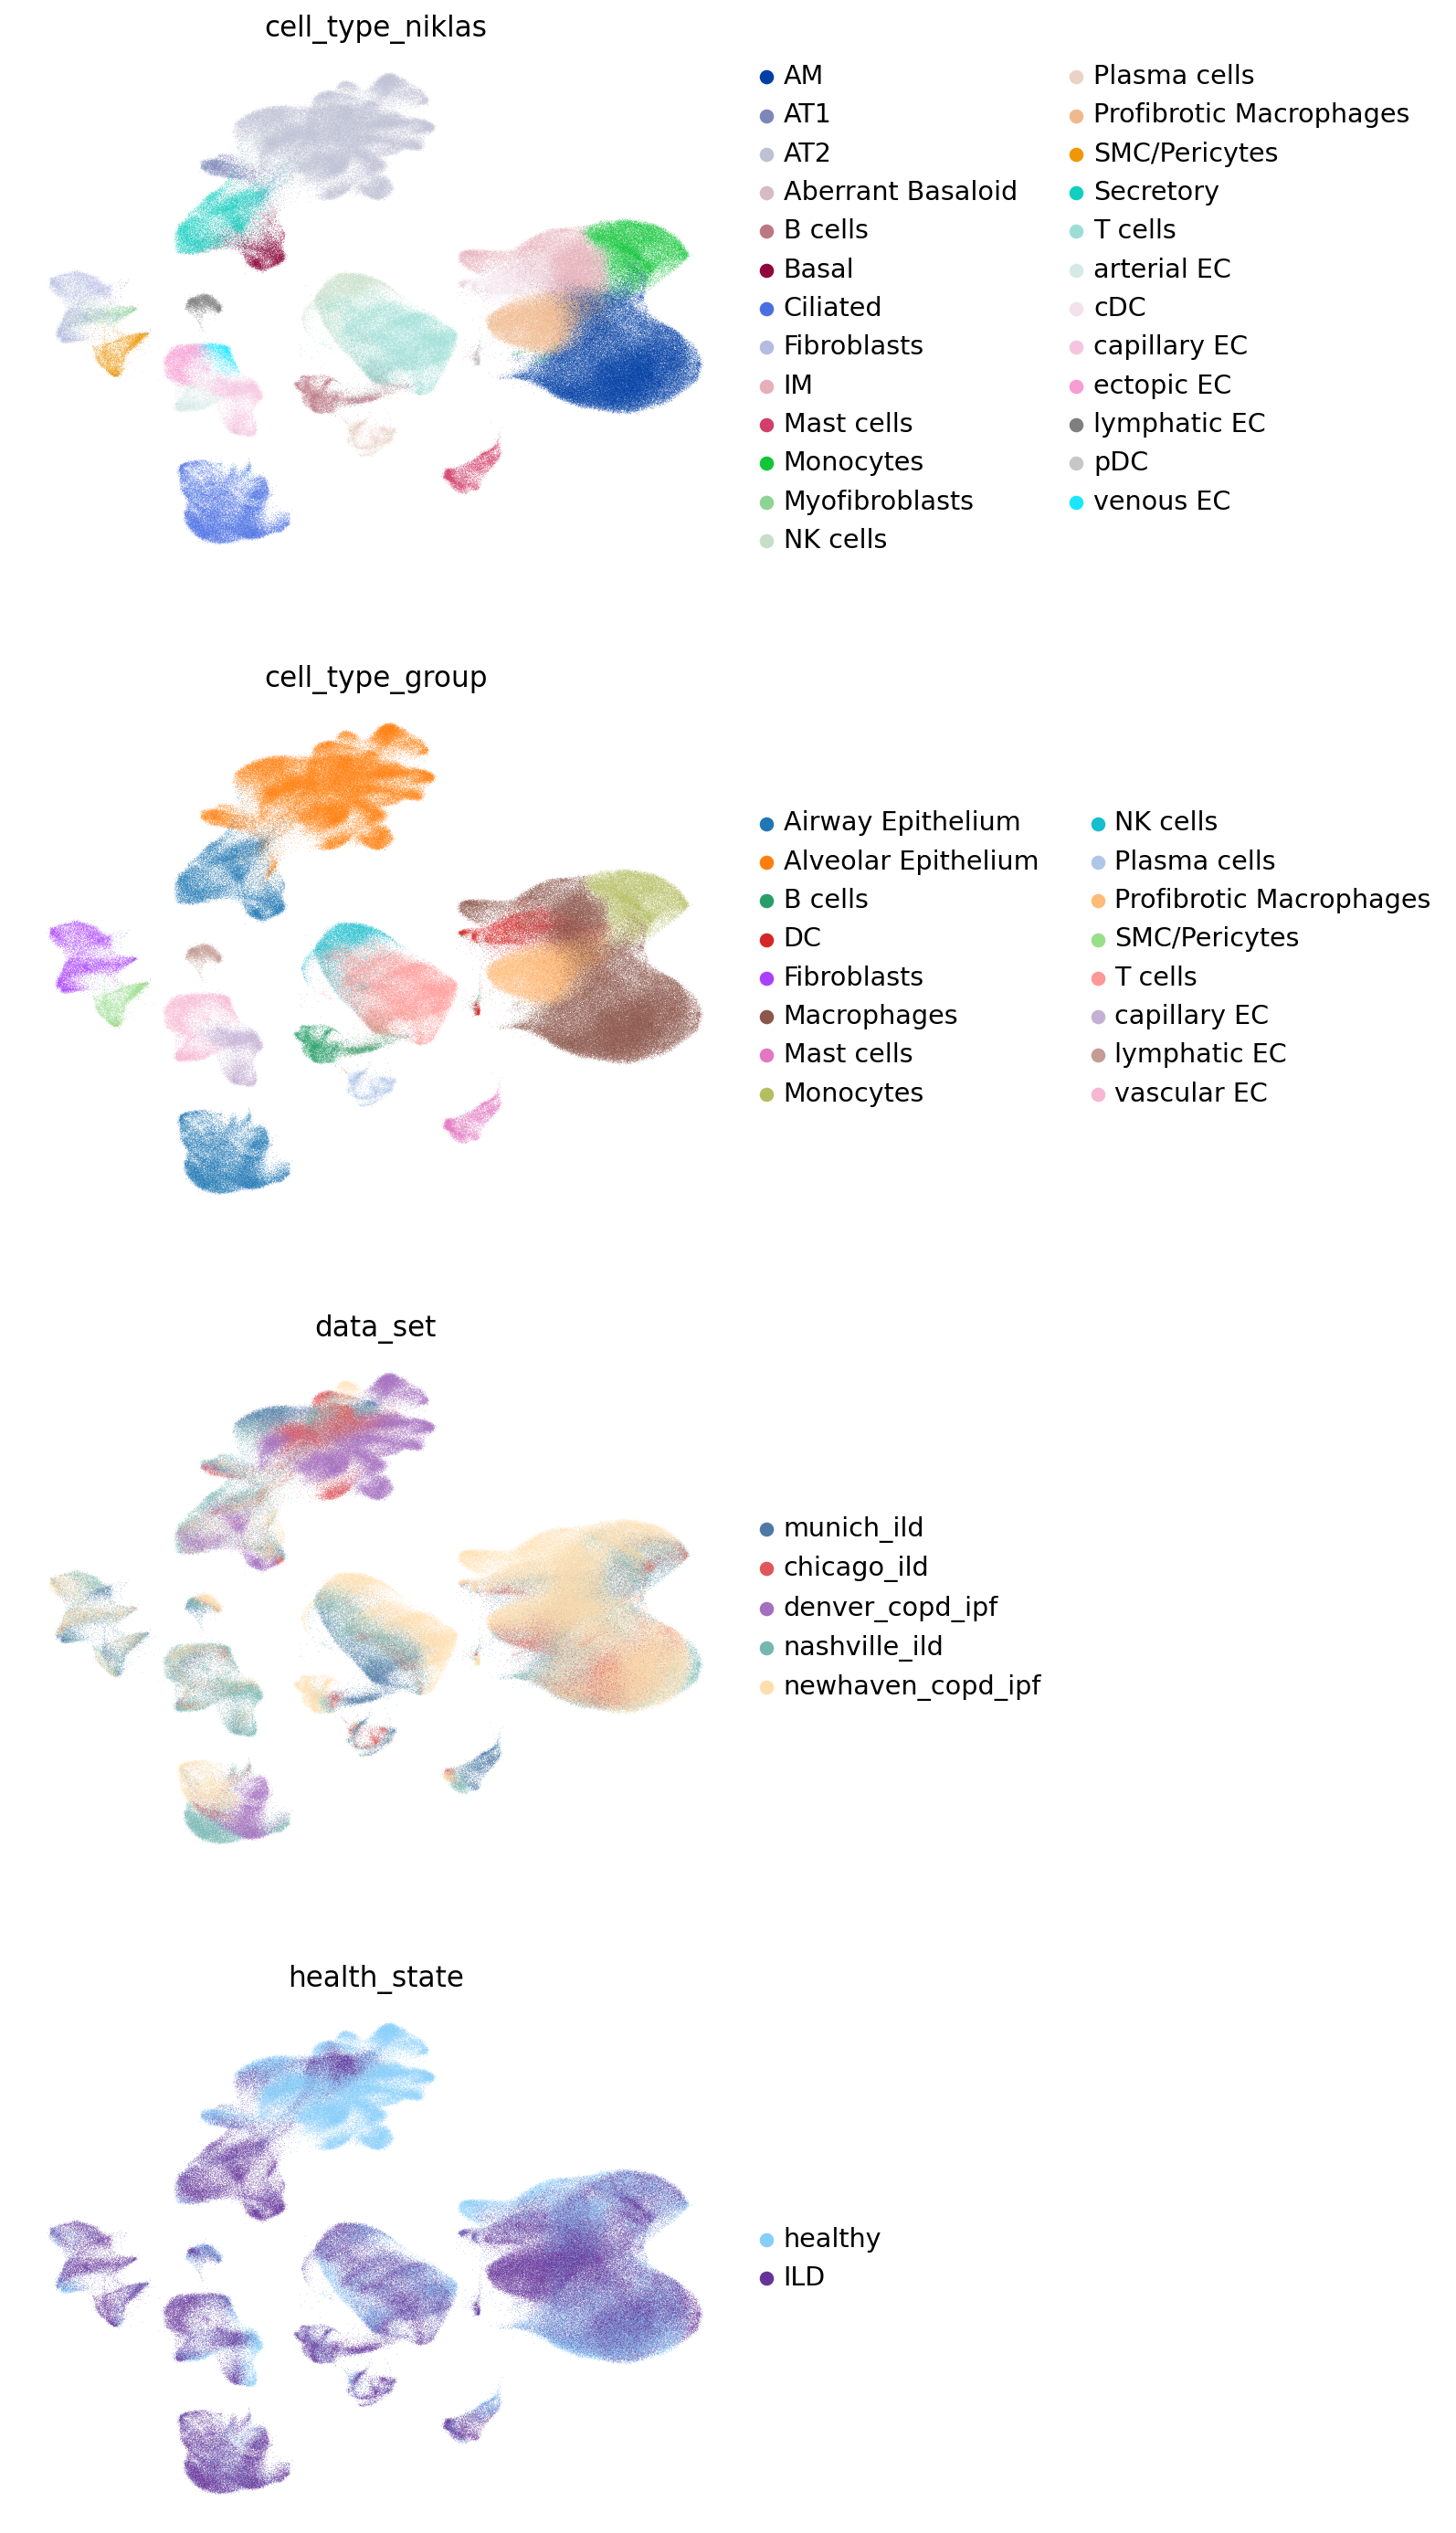

In [6]:
## overview UMAPs
sc.pl.umap(adata, color = ['cell_type_niklas',
                           'cell_type_group',
                           'data_set',
                           'health_state'], ncols = 1, frameon = False)

In [7]:
adata.obs['cell_type_nichenet'] = adata.obs.loc[:, ['cell_type_niklas', 'health_state']].agg('_'.join, axis = 1)
sc._utils.sanitize_anndata(adata)

/home/niklas/miniconda3/envs/niche_fibrosis_env/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'cell_type_nichenet' as categorical


In [8]:
adata.obs['cell_type_nichenet'] = ['Aberrant Basaloid' if ct.startswith('Aberrant Basaloid') else ct for ct in adata.obs['cell_type_nichenet']]
adata.obs['cell_type_nichenet'] = ['Myofibroblasts' if ct.startswith('Myofibroblasts') else ct for ct in adata.obs['cell_type_nichenet']]
adata.obs['cell_type_nichenet'] = ['ectopic EC' if ct.startswith('ectopic EC') else ct for ct in adata.obs['cell_type_nichenet']]
adata.obs['cell_type_nichenet'] = ['Profibrotic Macrophages' if ct.startswith('Profibrotic Macrophages') else ct for ct in adata.obs['cell_type_nichenet']]

In [9]:
adata.obs['cell_type_nichenet'].value_counts()

AT2_healthy                94895
AM_ILD                     63766
AM_healthy                 54841
Profibrotic Macrophages    43687
Ciliated_ILD               29630
T cells_ILD                28290
IM_healthy                 19896
T cells_healthy            18496
Secretory_ILD              18191
Monocytes_ILD              17727
AT2_ILD                    16653
IM_ILD                     15912
Monocytes_healthy          14101
cDC_ILD                    12307
B cells_ILD                 8681
Fibroblasts_ILD             8284
Basal_ILD                   8273
NK cells_ILD                7544
ectopic EC                  7235
capillary EC_healthy        5907
NK cells_healthy            5680
capillary EC_ILD            5482
Ciliated_healthy            5447
Mast cells_ILD              4864
SMC/Pericytes_ILD           4763
cDC_healthy                 4246
AT1_healthy                 3636
Plasma cells_ILD            3328
Myofibroblasts              2859
Fibroblasts_healthy         2660
arterial E

In [10]:
sub = adata[adata.obs.cell_type_nichenet.isin(['Aberrant Basaloid', 'Myofibroblasts', 'ectopic EC', 'SMC/Pericytes_ILD', 'Profibrotic Macrophages'])]

In [11]:
top_ligands = ['SERPINE1','CDH5','F8','HSPG2','ADAM15','A2M', 
               'PLAT','VWF','RARRES2','TIMP1','TNFSF10','LAMB1',
               'CCL14','JAG1','THBS1','ICAM1','CMTM8','APP','ESAM',
               'NTN4','FAT1','APOE','ITGB2','NID1','COL4A1','CYR61',
               'ICAM2','PTPRM','FBN1','SFRP2','COMP','CLEC11A',
               'IL33','MDK','BMP5','CRLF1','DSG2','ADAM9','CTGF',
               'PLXNB2','CD24','SLIT2','CADM1']

In [12]:
sub.obs['cell_type_nichenet'] = sub.obs['cell_type_nichenet'].astype('category')
sub.obs['cell_type_nichenet'] = sub.obs['cell_type_nichenet'].cat.reorder_categories(['Aberrant Basaloid',
                                                                                      'Myofibroblasts',
                                                                                      'ectopic EC',
                                                                                      'SMC/Pericytes_ILD',
                                                                                      'Profibrotic Macrophages'])

Trying to set attribute `.obs` of view, copying.


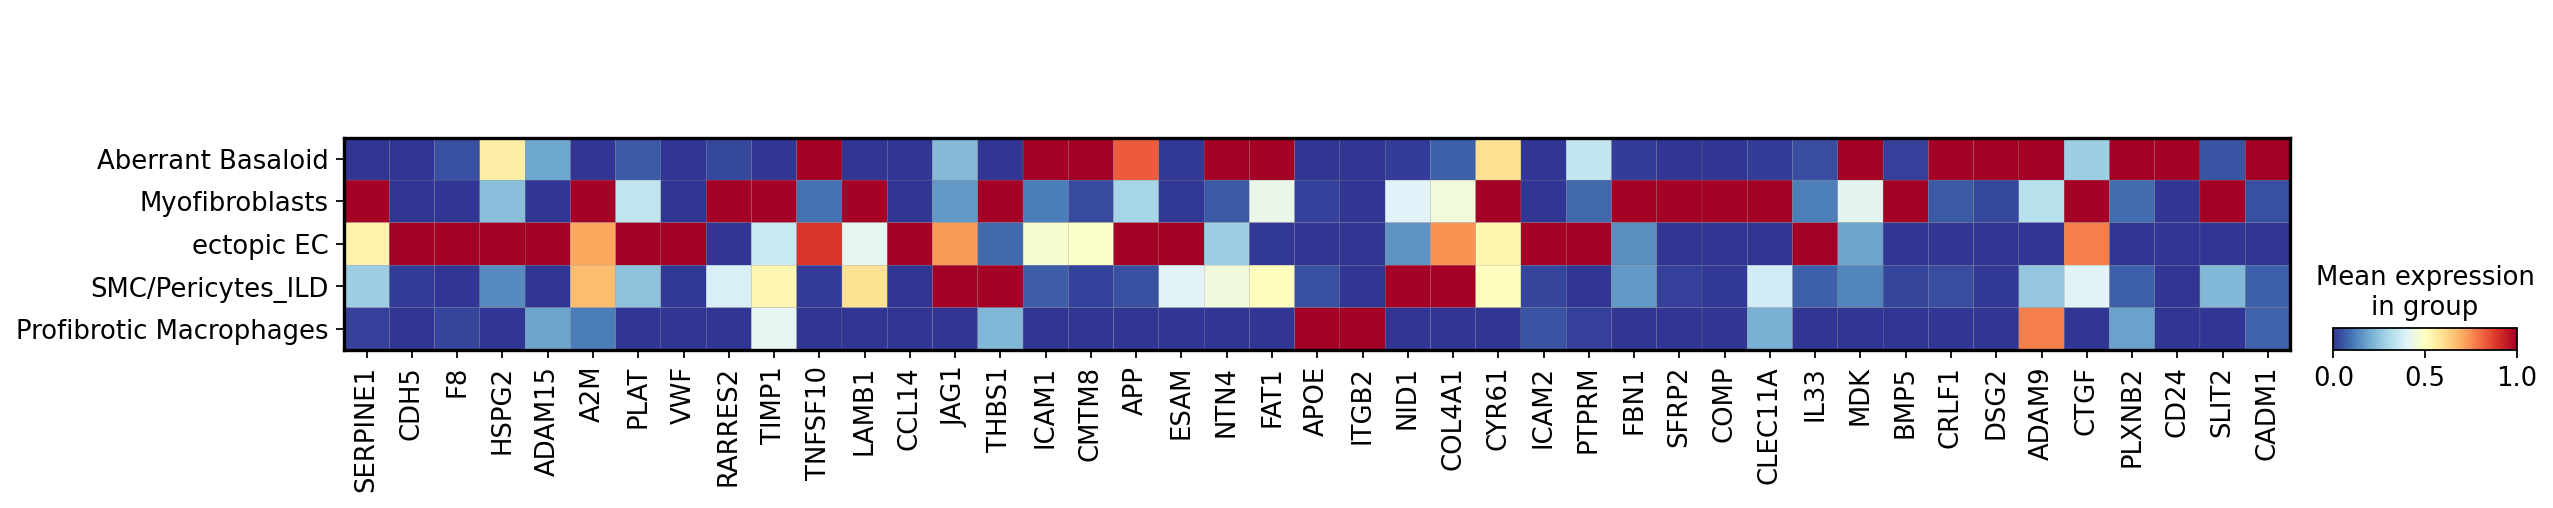

In [13]:
## custom heatmap
# global ligand expression (as predicted by NicheNet)
sc.pl.matrixplot(sub, top_ligands, groupby = 'cell_type_nichenet', standard_scale = 'var',
                 #layer = 'scaled', vmin = -1.5, vmax = 1.5,
                 dendrogram = False,  cmap = 'RdYlBu_r',
                 #colorbar_title = 'mean z-score', 
                 swap_axes = False, 
                 save = 'cell_circuit_ligand_expression.pdf' )

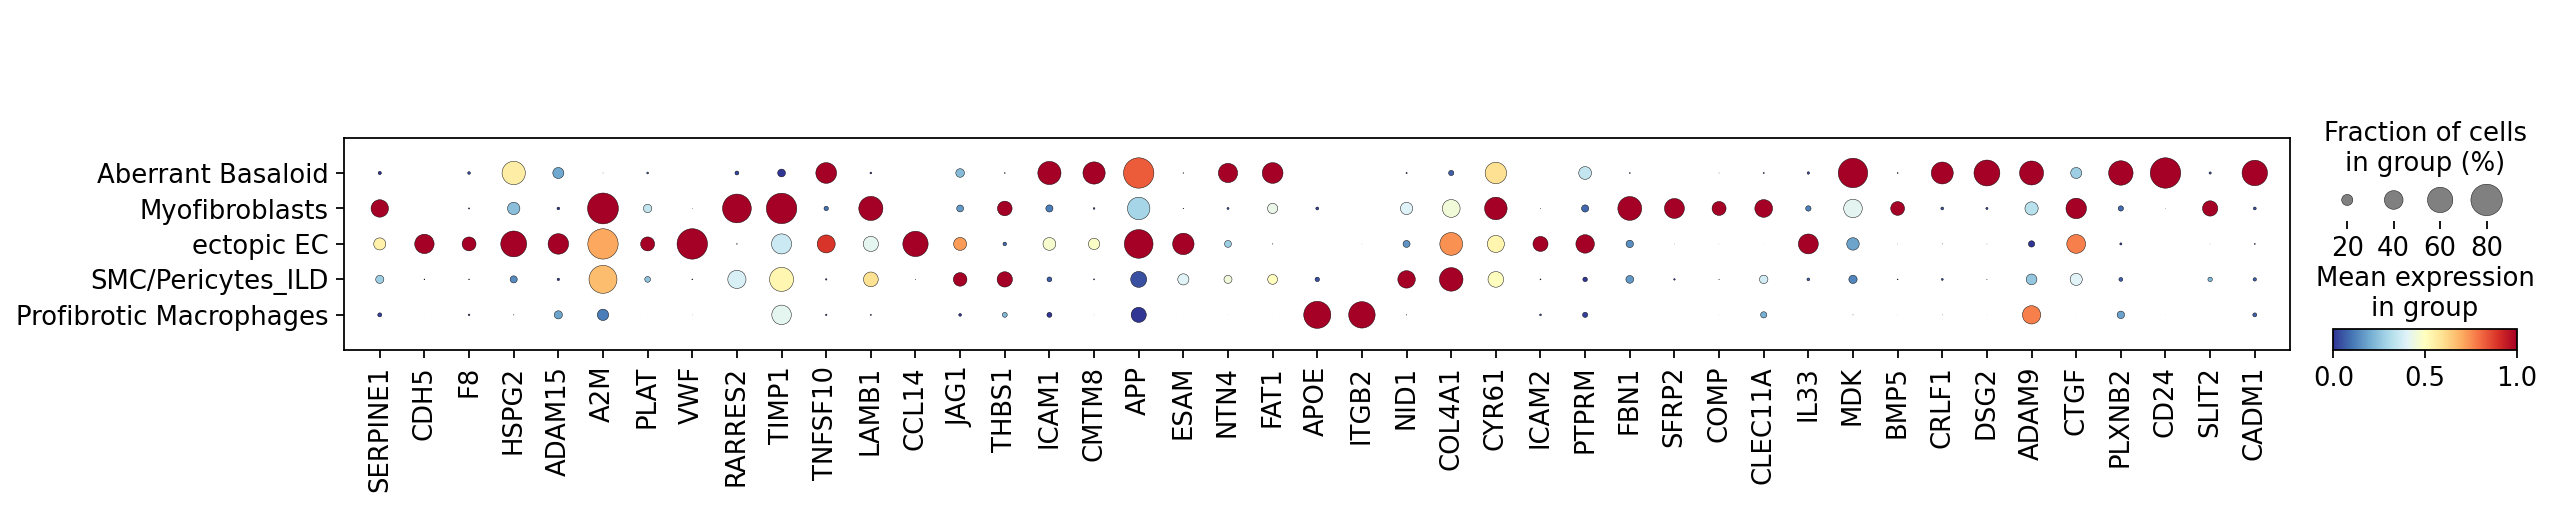

In [14]:
## custom heatmap
# global ligand expression (as predicted by NicheNet)
sc.pl.dotplot(sub, top_ligands, groupby = 'cell_type_nichenet', standard_scale = 'var',
                 #layer = 'scaled', vmin = -1.5, vmax = 1.5,
                 dendrogram = False,  cmap = 'RdYlBu_r',
                 #colorbar_title = 'mean z-score', 
                 swap_axes = False, 
                 save = 'cell_circuit_ligand_expression.pdf' )

In [26]:
top_ligands = ['CTGF',
 'THBS1',
 'NID1',
 'JAG1',
 'COL4A1',
 'LAMB1',
 'TFPI',
 'COL18A1',
 'APP',
 'COL1A1',
 'ITGB1',
 'CYR61',
 'CD99',
 'HSP90B1',
 'ADAM9',
 'SPP1',
 'PSAP',
 'ALCAM',
 'ITGB2',
 'ITGAM',
 'HLA-A',
 'RTN4',
 'GPNMB',
 'ANXA1',
 'CALM1',
 'HLA-DRA',
 'SEMA3C',
 'GRN',
 'LGALS3',
 'APOE',
 'VWF',
 'CDH5',
 'CD320',
 'PECAM1',
 'HLA-E',
 'JAM2',
 'IL33',
 'SELE',
 'PTPRM',
 'ADAM15',
 'ICAM2',
 'HSPG2',
 'TNFSF10',
 'TNC',
 'MDK',
 'FN1',
 'SFRP2',
 'LAMB2',
 'BMP5',
 'IGF1',
 'ROBO2',
 'FBN1',
 'THBS2',
 'PCDH7',
 'FGF7',
 'COMP',
 'NENF',
 'SLIT2',
 'LAMA2',
 'CRLF1',
 'AGRN',
 'PTPRF',
 'GDF15',
 'CDH2',
 'LAMC2',
 'EFNA5',
 'CMTM8',
 'GSTP1',
 'CDH1',
 'F11R',
 'LIPH',
 'NRG1',
 'CLSTN1',
 'CADM1',
 'TGFB2',
 'PLAU',
 'PTGS2',
 'ICAM1',
 'CDH3',
 'FAT1',
 'CELSR1',
 'OCLN',
 'DSG2',
 'PLXNB2']

In [27]:
top_ligands.reverse()

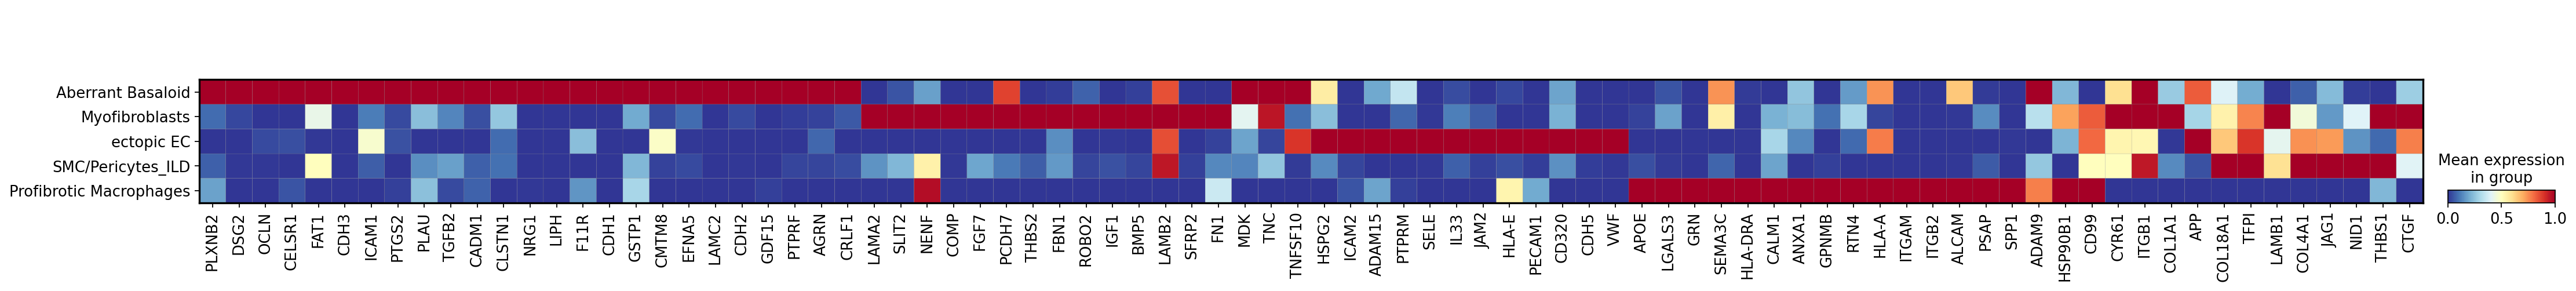

In [29]:
## custom heatmap
# global ligand expression (as predicted by NicheNet)
sc.pl.matrixplot(sub, top_ligands, groupby = 'cell_type_nichenet', standard_scale = 'var',
                 #layer = 'scaled', vmin = -1.5, vmax = 1.5,
                 dendrogram = False,  cmap = 'RdYlBu_r',
                 #colorbar_title = 'mean z-score', 
                 swap_axes = False, 
                 save = 'cell_circuit_pairwise_ligand_expression.pdf')